This notebook presents a summary analysis, sanity checks and preprocessing of the mimic-OMOP database.
The database has been obtained using the postgreSQL ETLs from: https://github.com/MIT-LCP/mimic-omop. 

Reproducible conda environment used: file db_analysis-linux-64.lock 

In [2]:
import sys
from pathlib import Path
import os
sys.path.insert(0,str(Path(os.path.abspath('')).parent))
from proj_config import *
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import pandas_utils
import concepts_toolbox
# Define local env variables
datadir = get_datadir() / "mimic-omop"

# Concept tables

In [2]:
concept_df = pd.read_csv(datadir/"concept.csv.gz")
concept_class_df = pd.read_csv(datadir/"concept_class.csv.gz")
concept_relationship_df = pd.read_csv(datadir/"concept_relationship.csv.gz")

/home/quentin/anaconda3/envs/pmsi_db_analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The concept_relationship table contains:
- hierarchical relationships between concepts: relationship_id 'Subsumes' (parent), or 'Is a' (child)
- mappings between different ontologies: relationship_id 'Mapped from' and 'Maps to'

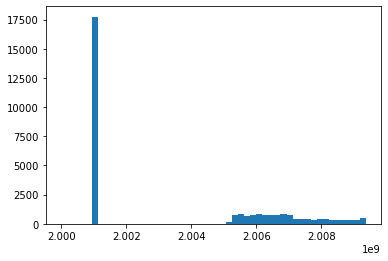

In [3]:
%matplotlib inline
plt.hist(concept_df.concept_id[concept_df.concept_id>200000000],bins=50);

In [14]:
concept_df.concept_id[concept_df.concept_id>200000000].max()

2009359722

# Person and visit tables

In [7]:
person_df = pd.read_csv(datadir/"person.csv.gz",usecols= ['person_id','gender_concept_id','birth_datetime'],
                        parse_dates=['birth_datetime'],infer_datetime_format=True)
visit_df = pd.read_csv(datadir/"visit_occurrence.csv.gz",usecols=['visit_occurrence_id','person_id','visit_start_date'],
                      parse_dates=['visit_start_date'],infer_datetime_format=True)

In [9]:
person_df.gender_concept_id.unique()

array([8507, 8532])

In [67]:
preproc_visit_df = pd.merge(visit_df,person_df,how='left',
        left_on='person_id',right_on='person_id')
preproc_visit_df.gender_concept_id = (preproc_visit_df.gender_concept_id==8532).astype(dtype='uint8')
preproc_visit_df.rename(columns={'gender_concept_id':"sex_F"},inplace=True)

In [68]:
preproc_visit_df['age'] = (preproc_visit_df.visit_start_date.dt.date-preproc_visit_df.birth_datetime.dt.date)
preproc_visit_df.age = preproc_visit_df.age.apply(lambda x: x.days/365.25)

(array([10781., 19303., 26276.,     0.,     0.,     0.,     0.,     0.,
            0.,  2616.]),
 array([  0.        ,  31.15537303,  62.31074606,  93.4661191 ,
        124.62149213, 155.77686516, 186.93223819, 218.08761123,
        249.24298426, 280.39835729, 311.55373032]),
 <BarContainer object of 10 artists>)

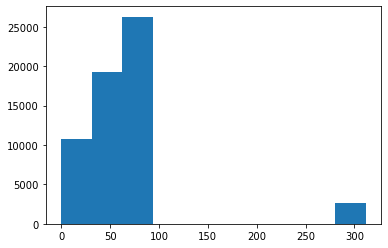

In [69]:
%matplotlib inline
plt.hist(preproc_visit_df.age)

From MIMIC docs:
Dates of birth which occur in the present time are not true dates of birth. Furthermore, dates of birth which occur before the year 1900 occur if the patient is older than 89. In these cases, the patient’s age at their first admission has been fixed to 300.

In [70]:
# Normalize by max age
preproc_visit_df.age = preproc_visit_df.age.clip(upper=89)/89.0

In [72]:
# Export age/sex table
preproc_visit_df.to_csv(datadir/"pre-processed/visits_agesex.csv.gz",columns=['visit_occurrence_id','person_id','sex_F','age'],index=False)

# Condition occurrence table preprocessing
## EDF initiale

In [6]:
diagnostics_df = pd.read_csv(datadir/"condition_occurrence.csv.gz")
diag_prof = diagnostics_df.profile_report()

In [5]:
diagnostics_df.head()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_date,condition_start_datetime,condition_end_date,condition_end_datetime,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id
0,336159169,392799187,198464,2153-01-11,2153-01-11 07:15:00,2153-01-13,2153-01-13 11:00:00,38000184,NaN,NaN,30549,NaN,55321,44825520.0,NaN,NaN
1,336176080,392807515,195559,2159-08-27,2159-08-27 08:30:00,2159-09-08,2159-09-08 13:50:00,38000184,NaN,NaN,33647,NaN,4413,44833580.0,NaN,NaN
2,335984902,392784957,437474,2158-03-21,2158-03-21 21:50:00,2158-04-06,2158-04-06 16:04:00,38000184,NaN,NaN,10854,NaN,99859,44826039.0,NaN,NaN
3,336063211,392795465,40481042,2169-03-24,2169-03-24 11:09:00,2169-04-03,2169-04-03 14:10:00,38000184,NaN,NaN,17475,NaN,42831,44824251.0,NaN,NaN
4,336159162,392799187,73614,2154-06-18,2154-06-18 02:27:00,2154-06-20,2154-06-20 16:25:00,38000184,NaN,NaN,30550,NaN,80707,44835139.0,NaN,NaN


In [ ]:
diag_prof.to_notebook_iframe()

Some background:
- On the different types of ICD9 and their mapping to SNOMED: https://www.ohdsi.org/web/wiki/doku.php?id=documentation:vocabulary:icd9cm

Observations:
- not all condition occurence are taken from the same source (21 unique values for condition_type_id) => check which information we're interested in.
- source ICD-9 value is a mix of ICD9 codes and text => assert valid ICD9 code before use, Some free text data come from the mimic ADMISSION table, maybe filtering on the condition_type_id will be sufficient.



## Look for the ICD9 reference concept

In [55]:
# Available ICD9 related concept classes
subprocess.check_call(['zgrep ICD9 "$1"', "_", datadir/"concept_class.csv.gz"],shell=True)

ICD9CM non-bill code,ICD9CM non-billable code,45754823
ICD9Proc non-bill,ICD9Proc non-billable code,45754824
ICD9CM code,ICD9CM code,44819259
ICD9CM E code,ICD9CM E code,44819260
ICD9CM V code,ICD9CM V code,44819261
ICD9Proc Chapter,ICD9Proc Chapter,32746


0

We should only be interested in ICD9CM and ICD9 CM non-billable codes (E and V are about external causes of injury and health status or care provider encounter respectively), ICD9Proc are procedures. 

In [66]:
# See how we can use the codes above for easy filtering
subprocess.check_call(['zgrep -H -m1 45754823 "$1/"*.csv.gz', "_", datadir],shell=True)

/home/quentin/Projects/completion_pmsi/data/mimic-omop/concept.csv.gz:45754823,ICD9CM non-billable code,Metadata,Concept Class,Concept Class,,OMOP generated,1970-01-01,2015-01-03,D
/home/quentin/Projects/completion_pmsi/data/mimic-omop/concept_class.csv.gz:ICD9CM non-bill code,ICD9CM non-billable code,45754823
/home/quentin/Projects/completion_pmsi/data/mimic-omop/drug_exposure.csv.gz:345754823,392784444,0,2151-02-22,2151-02-22 21:30:00,,,,38000180,,,,,,4128794,,96510,14013,397596982,Promod,2001023363,,,
/home/quentin/Projects/completion_pmsi/data/mimic-omop/fact_relationship.csv.gz:13,345749672,13,345754823,44818791
/home/quentin/Projects/completion_pmsi/data/mimic-omop/fact_relationship.csv.gz:13,344505334,13,345754823,44818791
/home/quentin/Projects/completion_pmsi/data/mimic-omop/fact_relationship.csv.gz:13,345749674,13,345754823,44818791
/home/quentin/Projects/completion_pmsi/data/mimic-omop/fact_relationship.csv.gz:13,345749671,13,345754823,44818791
/home/quentin/Projects/complet

0

So using the concept IDs for the concept classes directly seems useless, as there is no relationship defined outside the entries in the concept and concept_class tables...

Let's check using 'ICD9CM' string search:

In [68]:
subprocess.check_call(['zgrep -H -m10 ICD9CM "$1/"*.csv.gz', "_", datadir],shell=True)

/home/quentin/Projects/completion_pmsi/data/mimic-omop/concept.csv.gz:44819259,ICD9CM code,Metadata,Concept Class,Concept Class,,OMOP generated,1970-01-01,2015-01-03,D
/home/quentin/Projects/completion_pmsi/data/mimic-omop/concept.csv.gz:44819260,ICD9CM E code,Metadata,Concept Class,Concept Class,,OMOP generated,1970-01-01,2015-01-03,D
/home/quentin/Projects/completion_pmsi/data/mimic-omop/concept.csv.gz:44819261,ICD9CM V code,Metadata,Concept Class,Concept Class,,OMOP generated,1970-01-01,2015-01-03,D
/home/quentin/Projects/completion_pmsi/data/mimic-omop/concept.csv.gz:45754823,ICD9CM non-billable code,Metadata,Concept Class,Concept Class,,OMOP generated,1970-01-01,2015-01-03,D
/home/quentin/Projects/completion_pmsi/data/mimic-omop/concept.csv.gz:44829696,Cholera,Condition,ICD9CM,3-dig nonbill code,,001,1970-01-01,2099-12-31,
/home/quentin/Projects/completion_pmsi/data/mimic-omop/concept.csv.gz:44835564,Cholera due to vibrio cholerae,Condition,ICD9CM,4-dig billing code,,001.0,1970-01

0

Filter concepts based on vocabulary_id containing the 'ICD9CM' string:

In [5]:
# Query the corresponding rows
icd9_concepts = concept_df.query('vocabulary_id.str.contains("ICD9CM",na=False)')
# Check that it gives a single vocabulary_id
print("Uniques domain_id containing ICD9CM: " + str(icd9_concepts.domain_id.unique()))
print("Uniques vocabulary_id containing ICD9CM: " + str(icd9_concepts.vocabulary_id.unique()))
print("Uniques concept_class_id containing ICD9CM: " + str(icd9_concepts.concept_class_id.unique()))
icd9_concepts.head()

Uniques domain_id containing ICD9CM: ['Condition' 'Observation' 'Measurement' 'Procedure']
Uniques vocabulary_id containing ICD9CM: ['ICD9CM']
Uniques concept_class_id containing ICD9CM: ['3-dig nonbill code' '4-dig billing code' '4-dig nonbill code'
 '5-dig billing code' '3-dig billing code' 'ICD9CM code'
 '3-dig nonbill E code' '4-dig billing E code' '3-dig billing E code'
 '3-dig nonbill V code' '4-dig billing V code' '4-dig nonbill V code'
 '5-dig billing V code' '3-dig billing V code']


,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
116767,44829696,Cholera,Condition,ICD9CM,3-dig nonbill code,NaN,001,1970-01-01,2099-12-31,NaN
116768,44835564,Cholera due to vibrio cholerae,Condition,ICD9CM,4-dig billing code,NaN,001.0,1970-01-01,2099-12-31,NaN
116769,44823922,Cholera due to vibrio cholerae el tor,Condition,ICD9CM,4-dig billing code,NaN,001.1,1970-01-01,2099-12-31,NaN
116770,44827441,"Cholera, unspecified",Condition,ICD9CM,4-dig billing code,NaN,001.9,1970-01-01,2099-12-31,NaN
116771,44829697,Typhoid and paratyphoid fevers,Condition,ICD9CM,3-dig nonbill code,NaN,002,1970-01-01,2099-12-31,NaN


In [87]:
# Check whether they all existed in the concept_class table
assert all(pd.Series(icd9_concepts.concept_class_id.unique()).isin(concept_class_df.concept_class_id))
concept_class_df[concept_class_df['concept_class_id'].isin(icd9_concepts.concept_class_id.unique())]

,concept_class_id,concept_class_name,concept_class_concept_id
52,3-dig billing code,3-digit billing code,45754868
53,4-dig billing code,4-digit billing code,45754869
54,5-dig billing code,5-digit billing code,45754870
55,4-dig billing E code,4-digit billing E code,45754871
57,3-dig billing V code,3-digit billing V code,45754873
58,4-dig billing V code,4-digit billing V code,45754874
59,5-dig billing V code,5-digit billing V code,45754875
60,3-dig nonbill code,3-digit non-billing code,45754876
61,4-dig nonbill code,4-digit non-billing code,45754877
62,3-dig nonbill V code,3-digit non-billing V code,45754878


Let's keep all of them for now and see later if we need to remove the E and V classes

In [54]:
# Condition type concepts id meaning
unique_condition_types = diagnostics_df.condition_type_concept_id.unique()
concept_df[concept_df['concept_id'].isin(unique_condition_types)]

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
8396,38000184,Inpatient detail - 1st position,Type Concept,Condition Type,Condition Type,NaN,OMOP4822060,1970-01-01,2099-12-31,NaN
8397,38000185,Inpatient detail - 2nd position,Type Concept,Condition Type,Condition Type,NaN,OMOP4822061,1970-01-01,2099-12-31,NaN
8398,38000186,Inpatient detail - 3rd position,Type Concept,Condition Type,Condition Type,NaN,OMOP4822062,1970-01-01,2099-12-31,NaN
8399,38000187,Inpatient detail - 4th position,Type Concept,Condition Type,Condition Type,NaN,OMOP4822063,1970-01-01,2099-12-31,NaN
8400,38000188,Inpatient detail - 5th position,Type Concept,Condition Type,Condition Type,NaN,OMOP4822064,1970-01-01,2099-12-31,NaN
8401,38000189,Inpatient detail - 6th position,Type Concept,Condition Type,Condition Type,NaN,OMOP4822065,1970-01-01,2099-12-31,NaN
8402,38000190,Inpatient detail - 7th position,Type Concept,Condition Type,Condition Type,NaN,OMOP4822066,1970-01-01,2099-12-31,NaN
8403,38000191,Inpatient detail - 8th position,Type Concept,Condition Type,Condition Type,NaN,OMOP4822067,1970-01-01,2099-12-31,NaN
8404,38000192,Inpatient detail - 9th position,Type Concept,Condition Type,Condition Type,NaN,OMOP4822068,1970-01-01,2099-12-31,NaN
8405,38000193,Inpatient detail - 10th position,Type Concept,Condition Type,Condition Type,NaN,OMOP4822069,1970-01-01,2099-12-31,NaN


In [17]:
# Assert all icd9 codes are unique
assert all(icd9_concepts.concept_code.value_counts()==1)

## Filtering ICD9 codes produces a table of similar size to the original DIAGNOSIS_ICD
There are many sources of conditions inside the condition_occurrence table let's see if by filtering out broad ICD9 codes we obtain a different set of unique conditions:

In [7]:
icd_filtered_diagnostics_df = diagnostics_df[diagnostics_df['condition_source_concept_id'].isin(icd9_concepts.concept_id)]
unique_condition_types = icd_filtered_diagnostics_df.condition_type_concept_id.unique()
concept_df[concept_df['concept_id'].isin(unique_condition_types)]
icd_filtered_diagnostics_df.shape

(651000, 16)

This is about the size of the DIAGNOSES_ICD table of the original MIMIC (651047)

By filtering ICD9 related codes we have eliminated all the 'EHR chief complaint' source of conditions, let's see if doing it the other way around gives the same results:

In [13]:
notEHR_chief_diagnostics_df = diagnostics_df.query('condition_source_concept_id != "EHR Chief Complaint"')
print(notEHR_chief_diagnostics_df.shape)
print(all(icd_filtered_diagnostics_df['condition_occurrence_id'].isin(notEHR_chief_diagnostics_df.condition_occurrence_id)))

(716595, 16)
True


So most of the non ICD9 values are 'EHR chief complaint', but some are not. 

In [ ]:
notEHR_chief_not_ICD_concept = notEHR_chief_diagnostics_df[~notEHR_chief_diagnostics_df['condition_source_concept_id'].isin(icd9_concepts.concept_id)]
notEHR_chief_not_ICD_concept.profile_report().to_notebook_iframe()

~ 70% of the ~65000 condition reported as text and not 'EHR chief complaint' have been remapped to 950 distinct SNOMED concepts. Quite a few are still more common than the 100 cases bar used in the article from Sagi et al. Let's have a quick look on the existence of such entries in the original mimic table:

In [57]:
mimic_diagnostics_df = pd.read_csv(get_datadir()/"mimic/mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv.gz")
print(mimic_diagnostics_df['ICD9_CODE'].isna().sum())
mimic_diagnostics_df[mimic_diagnostics_df['ICD9_CODE'].isin(notEHR_chief_not_ICD_concept.condition_source_value)]

47


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
5251,5029,417,102633,NaN,NaN
8354,7969,690,174817,NaN,NaN
9691,10924,937,177274,NaN,NaN
18667,16813,1490,135580,NaN,NaN
27313,37428,3369,126808,NaN,NaN
39787,53456,4791,159800,NaN,NaN
55284,45143,4023,170307,NaN,NaN
82223,98541,8818,111608,NaN,NaN
92219,84252,7544,116945,NaN,NaN
97533,88308,7880,184025,NaN,NaN


So there are 47 entries with NA diagnostic, and 2 viral conjonctivitis that have been dropped in the ETL for a reason i do not understand, and most likely 1 or 2 things created

In [59]:
mimic_diagnostics_df[mimic_diagnostics_df['ICD9_CODE'].isin(notEHR_chief_not_ICD_concept.condition_source_value)].ICD9_CODE.unique()

array([nan, '0778'], dtype=object)

In [64]:
icd9_concepts.query('concept_code in "077.8"')

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
117785,44825158,Other viral conjunctivitis,Condition,ICD9CM,4-dig billing code,NaN,077.8,1970-01-01,2099-12-31,NaN


In [78]:
mimic_diagnostics_df.query('HADM_ID in [120813,135312]').sort_values(by=['HADM_ID','ICD9_CODE']) 

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
567020,587430,85828,120813,10.0,0778
567011,587421,85828,120813,1.0,07999
567017,587427,85828,120813,7.0,2449
567024,587434,85828,120813,14.0,2749
567021,587431,85828,120813,11.0,2859
567014,587424,85828,120813,4.0,28731
567022,587432,85828,120813,12.0,2875
567018,587428,85828,120813,8.0,4589
567013,587423,85828,120813,3.0,486
567015,587425,85828,120813,5.0,515


In [54]:
icd_filtered_diagnostics_df.query('condition_source_value=="0778"')

,condition_occurrence_id,person_id,condition_concept_id,condition_start_date,condition_start_datetime,condition_end_date,condition_end_datetime,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id
423546,336036941,392796367,380038,2180-04-15,2180-04-15 16:18:00,2180-04-20,2180-04-20 18:00:00,38000192,NaN,NaN,14586,NaN,0778,44825158.0,NaN,NaN
469842,336439629,392817759,380038,2138-03-27,2138-03-27 17:47:00,2138-04-01,2138-04-01 14:40:00,38000193,NaN,NaN,55467,NaN,0778,44825158.0,NaN,NaN


In [79]:
icd_filtered_diagnostics_df.query('visit_occurrence_id in [14586,55467]')[['visit_occurrence_id','condition_source_value','condition_source_concept_id']].sort_values(by=['visit_occurrence_id','condition_source_value'])

,visit_occurrence_id,condition_source_value,condition_source_concept_id
377399,14586,0521,44833234.0
44157,14586,0527,44821676.0
423546,14586,0778,44825158.0
345205,14586,2866,44820701.0
227739,14586,51882,44820899.0
98999,14586,570,44825528.0
164576,14586,5845,44833659.0
290901,14586,78552,44825805.0
230916,14586,99592,44827180.0
469842,55467,0778,44825158.0


I don't quite understand (probably a mistake of mine) why the two 0778 codes in the whole MIMIC stoud out in the previous cells, but it seems they are correctly mapped to 2 patients with the exact same set of diagnostics and then the 47 missing diags left are NA and could not be mapped.

## Diagnostics are unique in a visit_occurrence

In [52]:
assert all (icd_filtered_diagnostics_df.groupby(['visit_occurrence_id','condition_source_concept_id']).count()==1)

## Export filtered table

In [8]:
# Join with the icd9 concept table to get consistent ICD9 labels
diag_export_table = pd.merge(icd_filtered_diagnostics_df[['condition_occurrence_id', 'person_id', 'condition_concept_id','visit_occurrence_id','condition_source_value',
       'condition_source_concept_id']],
        icd9_concepts[['concept_id','domain_id','concept_name','concept_class_id','concept_code']],
        how='left',
        left_on='condition_source_concept_id',
        right_on='concept_id').drop(columns='condition_source_concept_id')

assert all(diag_export_table.condition_source_value==diag_export_table.concept_code.str.replace('.',"",regex=False))
diag_export_table.drop(columns='condition_source_value',inplace=True)
diag_export_table.rename(columns={'condition_concept_id':'snomed_concept_id','concept_id':'icd9_concept_id',
                                 'concept_code':'icd9_code','concept_name':'icd9_name','concept_class_id':'icd9_concept_class_id'},inplace=True)


In [9]:
diag_export_table.head()

,condition_occurrence_id,person_id,snomed_concept_id,visit_occurrence_id,icd9_concept_id,domain_id,icd9_name,icd9_concept_class_id,icd9_code
0,336159169,392799187,198464,30549,44825520,Condition,Incisional hernia without mention of obstructi...,5-dig billing code,553.21
1,336176080,392807515,195559,33647,44833580,Condition,"Abdominal aneurysm, ruptured",4-dig billing code,441.3
2,335984902,392784957,437474,10854,44826039,Condition,Other postoperative infection,5-dig billing code,998.59
3,336063211,392795465,40481042,17475,44824251,Condition,Acute diastolic heart failure,5-dig billing code,428.31
4,336159162,392799187,73614,30550,44835139,Condition,Closed fracture of seven ribs,5-dig billing code,807.07


In [10]:
diag_export_table.to_csv(datadir/"pre-processed/diagnoses.csv.gz",index=False)

## Section TODO
- [ ] ~~check if numbers match with Sagi et al applying the same filters~~ => shall be done in further analysis script
- [ ] ~~check if string diagnostics are mapped to precise SNOMED concepts, and if yes, if they can be mapped back to ICD9 non leaf concepts~~ => not in the original mimic diagnosis table
- [X] check repeated diagnostics in a single visit_occurrence
- [X] check non "EHR chief complaint" conditions that have been excluded by the ICD9 filter 
- [ ] check sejour match between raw mimic and omop(ensemble of dg via group by + hash)

# Drug exposure table preprocessing

## EDF initiale

In [6]:
# Assign dtypes to reduce memory requirement and get reproducible results upon reading by chunk
drug_exp_dtypes = {'drug_exposure_id': np.uint64, 'person_id': np.uint64,'drug_concept_id':'Int64',
                   'drug_type_concept_id':'Int64','refills':'Int64',
                  'quantity':'Float64','days_supply':'Int64', 'route_concept_id':'Int64',
                  'visit_occurrence_id': np.uint64, 'visit_detail_id':'Int64', 'drug_source_concept_id':'Int64',
                   'quantity_source_value':str,'drug_source_value':str}
date_cols = ['drug_exposure_start_date','drug_exposure_end_date','verbatim_end_date']


In [8]:
def filter_drug_type(df):
    return pd.DataFrame.query(df,'drug_type_concept_id==38000177')

In [59]:
drug_exp_types = pd.read_csv(datadir/"drug_exposure.csv.gz",usecols=['drug_type_concept_id'])
print(drug_exp_types.drug_type_concept_id.value_counts())

38000180    20778301
38000177     4165275
Name: drug_type_concept_id, dtype: int64


From the concepts table:
- 38000177,Prescription written,Type Concept,Drug Type,Drug Type,,OMOP4822241,1970-01-01,2099-12-31,
- 38000180,Inpatient administration,Type Concept,Drug Type,Drug Type,,OMOP4822244,1970-01-01,2099-12-31,

Filtering on "Prescription written" would thus lead to a table of almost equal size compared with the initial Mimic prescription table (4,156,450 rows)

In [63]:
%%time
## All "Prescription written" rows are on top of the file thus there's no point going past 4200000 rows read
drug_exposure_df = pandas_utils.read_filter_csv_by_chunk(datadir/"drug_exposure.csv.gz",
                                                         filter_func=filter_drug_type,
                                                         chunksize=100000,nrows=4200000,
                                                        dtype=drug_exp_dtypes,parse_dates=date_cols)

<timed exec>:2: DtypeWarning: Columns (9,19) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 30.8 s, sys: 256 ms, total: 31.1 s
Wall time: 31.1 s


In [40]:
drug_exposure_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4165275 entries, 0 to 4165274
Data columns (total 24 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   drug_exposure_id              int64  
 1   person_id                     int64  
 2   drug_concept_id               int64  
 3   drug_exposure_start_date      object 
 4   drug_exposure_start_datetime  object 
 5   drug_exposure_end_date        object 
 6   drug_exposure_end_datetime    object 
 7   verbatim_end_date             float64
 8   drug_type_concept_id          int64  
 9   stop_reason                   object 
 10  refills                       float64
 11  quantity                      float64
 12  days_supply                   float64
 13  sig                           float64
 14  route_concept_id              float64
 15  lot_number                    float64
 16  provider_id                   float64
 17  visit_occurrence_id           int64  
 18  visit_detail_id       

In [7]:
drug_exposure_df.head()

,drug_exposure_id,person_id,drug_concept_id,drug_exposure_start_date,drug_exposure_start_datetime,drug_exposure_end_date,drug_exposure_end_datetime,verbatim_end_date,drug_type_concept_id,stop_reason,...,route_concept_id,lot_number,provider_id,visit_occurrence_id,visit_detail_id,drug_source_value,drug_source_concept_id,route_source_value,dose_unit_source_value,quantity_source_value
0,396803253,392815432,0,2106-09-07,2106-09-07 00:00:00,2106-09-08,2106-09-08 00:00:00,NaN,38000177,NaN,...,4139962.0,NaN,NaN,56351,NaN,0.0,NaN,SC,VIAL,0
1,396821890,392819347,0,2187-10-26,2187-10-26 00:00:00,2187-10-28,2187-10-28 00:00:00,NaN,38000177,NaN,...,4139962.0,NaN,NaN,58698,NaN,0.0,NaN,SC,VIAL,0
2,396808816,392815414,0,2149-02-13,2149-02-13 00:00:00,2149-02-13,2149-02-13 00:00:00,NaN,38000177,NaN,...,4112421.0,NaN,NaN,58519,NaN,0.0,NaN,IV,mL,50
3,396821892,392819347,0,2187-10-27,2187-10-27 00:00:00,2187-10-29,2187-10-29 00:00:00,NaN,38000177,NaN,...,4112421.0,NaN,NaN,58698,NaN,0.0,NaN,IV,mL,200
4,396808830,392815420,40141424,2116-05-15,2116-05-15 00:00:00,2116-05-17,2116-05-17 00:00:00,NaN,38000177,NaN,...,4112421.0,NaN,NaN,56337,NaN,0.0,NaN,IV,SYR,0.6


In [16]:
drug_exposure_df.route_concept_id.value_counts()

4112421.0     2381133
4128794.0     1309168
4139962.0      214038
45956874.0      83428
4302612.0       45620
4115462.0       44202
4231622.0       29624
4157760.0       20367
45956871.0      11402
4225555.0        9590
4262099.0        7496
4292110.0        4755
4156707.0         809
4217202.0         716
4136280.0         427
4023156.0         345
4243022.0         338
45956879.0        207
4186832.0         193
4128792.0         159
4224886.0          47
4181897.0          41
4006860.0          12
4222259.0           2
Name: route_concept_id, dtype: int64

In [ ]:
drug_prof = drug_exposure_df.sample(n=200000).profile_report()
drug_prof.to_notebook_iframe()

Observations (pandas profiling on 200000 random rows of written prescriptions):
- verbatim_end_date has 200000 (100.0%) missing values 
- stop_reason has 200000 (100.0%) missing values 
- refills has 200000 (100.0%) missing values 
- days_supply has 200000 (100.0%) missing values 
- sig has 200000 (100.0%) missing values 
- lot_number has 200000 (100.0%) missing values 
- provider_id has 200000 (100.0%) missing values 
- visit_detail_id has 200000 (100.0%) missing values 
- drug_source_concept_id has 200000 (100.0%) missing values 
- drug_concept_id has 27420 (13.7%) zeros 
- quantity has 1.9% zeros and 5.7% missing
- route_concept_id is almost complete, 23 unique values vs 61 for the route_source_value
- 2192 distinct drug_concept_id vs 1602 in Sagi et al

In [11]:
# stop_reason_test = 
all(pd.read_csv(datadir/"drug_exposure.csv.gz",usecols=['stop_reason']).stop_reason.isna())

/home/quentin/anaconda3/envs/pmsi_db_analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


False

In [12]:
drug_exposure_df = pd.read_csv(datadir/"drug_exposure.csv.gz",nrows=100)
drug_exposure_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   drug_exposure_id              100 non-null    int64  
 1   person_id                     100 non-null    int64  
 2   drug_concept_id               100 non-null    int64  
 3   drug_exposure_start_date      100 non-null    object 
 4   drug_exposure_start_datetime  100 non-null    object 
 5   drug_exposure_end_date        100 non-null    object 
 6   drug_exposure_end_datetime    100 non-null    object 
 7   verbatim_end_date             0 non-null      float64
 8   drug_type_concept_id          100 non-null    int64  
 9   stop_reason                   0 non-null      float64
 10  refills                       0 non-null      float64
 11  quantity                      98 non-null     float64
 12  days_supply                   0 non-null      float64
 13  sig   

In [19]:
drug_exposure_df = pd.read_csv(datadir/"drug_exposure.csv.gz",nrows=100,dtype=drug_exp_dtypes,parse_dates=date_cols)
drug_exposure_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   drug_exposure_id              100 non-null    Int64         
 1   person_id                     100 non-null    Int64         
 2   drug_concept_id               100 non-null    Int64         
 3   drug_exposure_start_date      100 non-null    datetime64[ns]
 4   drug_exposure_start_datetime  100 non-null    object        
 5   drug_exposure_end_date        100 non-null    datetime64[ns]
 6   drug_exposure_end_datetime    100 non-null    object        
 7   verbatim_end_date             0 non-null      datetime64[ns]
 8   drug_type_concept_id          100 non-null    Int64         
 9   stop_reason                   0 non-null      float64       
 10  refills                       0 non-null      Int64         
 11  quantity                      98 

In [43]:
%%time
drug_exp_skip_cols = ['lot_number','provider_id','verbatim_end_date','stop_reason','refills','days_supply','sig',
                     'visit_detail_id','drug_exposure_start_datetime','drug_exposure_end_datetime']
date_cols = ['drug_exposure_start_date','drug_exposure_end_date']

## All "Prescription written" rows are on top of the file, there's no point going past 4200000 rows read
drug_exposure_df = pandas_utils.read_filter_csv_by_chunk(datadir/"drug_exposure.csv.gz",
                                                         filter_func=filter_drug_type,
                                                         chunksize=100000,nrows=4200000,
                                                        dtype=drug_exp_dtypes,parse_dates=date_cols,
                                                        usecols= lambda x: x not in drug_exp_skip_cols)

CPU times: user 23.3 s, sys: 2.81 s, total: 26.1 s
Wall time: 30.5 s


In [38]:
drug_exposure_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4165275 entries, 0 to 4165274
Data columns (total 15 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   drug_exposure_id            uint64        
 1   person_id                   uint64        
 2   drug_concept_id             Int64         
 3   drug_exposure_start_date    datetime64[ns]
 4   drug_exposure_end_date      datetime64[ns]
 5   drug_exposure_end_datetime  datetime64[ns]
 6   drug_type_concept_id        Int64         
 7   quantity                    Float64       
 8   route_concept_id            Int64         
 9   visit_occurrence_id         uint64        
 10  drug_source_value           object        
 11  drug_source_concept_id      Int64         
 12  route_source_value          object        
 13  dose_unit_source_value      object        
 14  quantity_source_value       object        
dtypes: Float64(1), Int64(4), datetime64[ns](3), object(4), uint64(3)
m

## RxNorm concepts relationships
A lot of details on the relationships on the ohdsi website: https://www.ohdsi.org/web/wiki/doku.php?id=documentation:vocabulary:atc

And the reference on the NIH website: https://www.nlm.nih.gov/research/umls/rxnorm/overview.html

The relationship tables gives relationship between different ontologies, and inside an ontology.
The concept_relationship table can be used to standardize RxNorm codes.



In [12]:
rxnorm_concepts = concept_df.query('vocabulary_id.str.contains("RxNorm",na=False)') # get both RxNorm and RxNorm Extension

In [17]:
rxnorm_concepts.head()

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
1684289,40224176,amlodipine 5 MG / hydrochlorothiazide 12.5 MG ...,Drug,RxNorm,Branded Drug,S,1000000,2010-09-05,2099-12-31,NaN
1684290,40224178,amlodipine 5 MG / hydrochlorothiazide 25 MG / ...,Drug,RxNorm,Clinical Drug,S,1000001,2010-09-05,2099-12-31,NaN
1684291,40224677,Tribenzor 40/5/25,Drug,RxNorm,Brand Name,NaN,1000002,2010-09-05,2013-03-31,D
1684292,40224180,amlodipine 5 MG / hydrochlorothiazide 25 MG / ...,Drug,RxNorm,Branded Drug Comp,S,1000003,2010-09-05,2099-12-31,NaN
1684293,40224158,Amlodipine / Hydrochlorothiazide / Olmesartan ...,Drug,RxNorm,Branded Drug Form,NaN,1000004,2010-09-05,2013-03-31,U


In [3]:
rxnorm_relationships = pd.read_csv(datadir/"relationship.csv.gz").query('relationship_name.str.contains("RxNorm",na=False)')

In [8]:
from IPython.display import display as dsp
with pd.option_context('display.max_rows', None,):
    dsp(rxnorm_relationships)

,relationship_id,relationship_name,is_hierarchical,defines_ancestry,reverse_relationship_id,relationship_concept_id
34,ETC - RxNorm,ETC to RxNorm (FDB),1,1,RxNorm - ETC,44818809
37,Precise ing of,Precise ingredient of (RxNorm),0,0,Has precise ing,44818813
38,Tradename of,Tradename of (RxNorm),0,0,Has tradename,44818814
39,RxNorm dose form of,Dose form of (RxNorm),1,0,RxNorm has dose form,44818815
40,Form of,Form of (RxNorm),0,0,Has form,44818816
41,RxNorm ing of,Ingredient of (RxNorm),1,1,RxNorm has ing,44818817
42,Consists of,Consists of (RxNorm),1,0,Constitutes,44818818
43,Contained in,Is contained in (RxNorm),1,1,Contains,44818819
44,Reformulated in,Reformulated in (RxNorm),0,1,Reformulation of,44818820
62,RxNorm - NDFRT eq,RxNorm to NDF-RT equivalent (RxNorm),0,0,NDFRT - RxNorm eq,44818839


## Mapping to different Rxnorm concept_class
### Initial concept_class distribution

In [44]:
drugs_concept_classes = pd.merge(drug_exposure_df[['drug_concept_id','visit_occurrence_id']],rxnorm_concepts[['concept_id','concept_class_id','concept_name']],
                                 left_on='drug_concept_id',right_on='concept_id',how='left')

In [45]:
# Number of occurences
round(drugs_concept_classes.concept_class_id.value_counts(dropna=False)/float(drugs_concept_classes.shape[0]),4)

Clinical Drug          0.3304
Quant Clinical Drug    0.3024
Branded Drug           0.1601
NaN                    0.1377
Quant Branded Drug     0.0384
Clinical Drug Form     0.0228
Ingredient             0.0065
Branded Drug Form      0.0010
Clinical Drug Comp     0.0004
Branded Drug Comp      0.0001
Branded Pack           0.0001
Precise Ingredient     0.0000
Clinical Pack          0.0000
Name: concept_class_id, dtype: float64

In [46]:
# Number of unique codes
drugs_concept_classes.groupby(by='drug_concept_id').first().concept_class_id.value_counts(dropna=False)

Clinical Drug          1295
Branded Drug           1164
Quant Branded Drug      301
Quant Clinical Drug     282
Branded Drug Comp       246
Clinical Drug Comp      204
Ingredient              167
Branded Drug Form        82
Clinical Drug Form       41
Branded Pack             20
Precise Ingredient        2
NaN                       1
Clinical Pack             1
Name: concept_class_id, dtype: int64

### Mapping to ingredients

In [13]:
%%time
drug_ing = concepts_toolbox.map_to_rxnorm_ingredient(drug_exposure_df[['visit_occurrence_id','drug_concept_id']],
                                                     concept_relationship_df,rxnorm_concepts,strict=False)

/home/quentin/anaconda3/envs/pmsi_db_analysis/lib/python3.10/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


CPU times: user 7.03 s, sys: 3.72 s, total: 10.8 s
Wall time: 13.3 s


In [48]:
drugs_ing_concept_classes = pd.merge(drug_ing[['rxnorm_ingredient','drug_concept_id']],rxnorm_concepts[['concept_id','concept_class_id','concept_name']],
                                 left_on='rxnorm_ingredient',right_on='concept_id',how='left')

print(round(
drugs_ing_concept_classes.concept_class_id.value_counts(dropna=False)/float(drugs_ing_concept_classes.shape[0]),4))
print(drugs_ing_concept_classes.concept_class_id.value_counts(dropna=False))

Ingredient            0.8826
NaN                   0.1168
Clinical Drug Comp    0.0005
Branded Drug Comp     0.0000
Name: concept_class_id, dtype: float64
Ingredient            4333794
NaN                    573632
Clinical Drug Comp       2574
Branded Drug Comp           4
Name: concept_class_id, dtype: int64


In [49]:
# Number of unique concept_id when loosely brought back to ingredients
len(drugs_ing_concept_classes.rxnorm_ingredient.unique())

1165

In [50]:
# and their partition
drugs_ing_concept_classes.groupby(by='rxnorm_ingredient').first().concept_class_id.value_counts(dropna=False)

Ingredient            1158
Clinical Drug Comp       5
NaN                      1
Branded Drug Comp        1
Name: concept_class_id, dtype: int64

Some drugs cannot be brought back to ingredients, e.g some immunological products (e.g concept_id 19098759 corresponds to "Rabbit anti-human T-lymphocyte globulin 5 MG/ML,Drug,RxNorm,Clinical Drug Comp", and only has 2 relations (consistitutes and tradename).
For such examples we keep the concept_id with concept_class closest to the ingredient concept_class.

In [28]:
# check number of visits removed when dropping visits with unkown drug
print("Total number of visits: " + str(drug_ing.visit_occurrence_id.unique().shape[0]))
print("Average number of drugs entries per visit: " + str(drug_ing.groupby('visit_occurrence_id').count().mean().rxnorm_ingredient))
print("Average number of unique ingredient entries per visit: " + str(drug_ing.groupby('visit_occurrence_id')['rxnorm_ingredient'].nunique().mean()))

print("Total number of visits left after filtering out visits containing unknown drugs: " +
      str(drug_ing.groupby('visit_occurrence_id').filter(lambda x: (x['rxnorm_ingredient']!=0).all()).visit_occurrence_id.unique().shape[0]))
print("Average number of drugs entries per visit left after filtering: " +
      str(drug_ing.groupby('visit_occurrence_id').filter(lambda x: (x['rxnorm_ingredient']!=0).all()).groupby(by='visit_occurrence_id').count().mean().rxnorm_ingredient))
print("Average number of unique ingredient entries per visit left after filtering: " + str(drug_ing.groupby('visit_occurrence_id').filter(lambda x: (x['rxnorm_ingredient']!=0).all()).groupby('visit_occurrence_id')['rxnorm_ingredient'].nunique().mean()))

Total number of visits: 50216
Average number of drugs entries per visit: 97.77768042058308
Average number of unique ingredient entries per visit: 34.946292018480165
Total number of visits left after filtering out visits containing unknown drugs: 2167
Average number of drugs entries per visit left after filtering: 23.333179510844484
Average number of unique ingredient entries per visit left after filtering: 14.938163359483157


In [35]:
# check number of unmapped drugs with missing source
print(drug_exposure_df.query('drug_concept_id==0').shape[0])
print(drug_exposure_df.query('drug_source_value=="0"').shape[0])
drug_exposure_df.query('drug_concept_id==0').drug_source_value.value_counts()

573632
586586


0              494387
61553008348     19940
17314931102      9142
62584078833      8266
66689036430      5912
                ...  
54569188401         1
72140085731         1
49281000610         1
51079029072         1
49281000950         1
Name: drug_source_value, Length: 125, dtype: int64

The source value is missing for most of the unmapped drugs, not much to gain to try and remap the ones with none missing source value.

## Export filtered table

In [44]:
drug_ing = concepts_toolbox.map_to_rxnorm_ingredient(drug_exposure_df,
                                                     concept_relationship_df,rxnorm_concepts,strict=False,drug_concept_id_col='drug_concept_id')
drug_ing = pd.merge(drug_ing,rxnorm_concepts[['concept_id','concept_name']],
                                 left_on='rxnorm_ingredient',right_on='concept_id',how='left')
drug_ing.drop(columns="concept_id",inplace=True)
drug_ing.rename(columns={"concept_name":"rxnorm_ingredient_name","rxnorm_ingredient":"rxnorm_ingredient_id"},inplace=True)
drug_ing.head()

,drug_exposure_id,person_id,drug_concept_id,drug_exposure_start_date,drug_exposure_end_date,drug_type_concept_id,quantity,route_concept_id,visit_occurrence_id,drug_source_value,drug_source_concept_id,route_source_value,dose_unit_source_value,quantity_source_value,rxnorm_ingredient_id,rxnorm_ingredient_name
0,396803253,392815432,0,2106-09-07,2106-09-08,38000177,0.0,4139962,56351,0,<NA>,SC,VIAL,0,0.0,NaN
1,396821890,392819347,0,2187-10-26,2187-10-28,38000177,0.0,4139962,58698,0,<NA>,SC,VIAL,0,0.0,NaN
2,396808816,392815414,0,2149-02-13,2149-02-13,38000177,50.0,4112421,58519,0,<NA>,IV,mL,50,0.0,NaN
3,396821892,392819347,0,2187-10-27,2187-10-29,38000177,200.0,4112421,58698,0,<NA>,IV,mL,200,0.0,NaN
4,396808830,392815420,40141424,2116-05-15,2116-05-17,38000177,0.6,4112421,56337,0,<NA>,IV,SYR,0.6,967823.0,sodium chloride


In [56]:
keep_cols_list = ['person_id','visit_occurrence_id','drug_concept_id','drug_exposure_start_date','drug_exposure_end_date',
                  'rxnorm_ingredient_id','rxnorm_ingredient_name']
unique_ingredients = drug_ing.groupby(by=['visit_occurrence_id',
                                                'rxnorm_ingredient_id']).agg({'drug_exposure_start_date':'min',
                                                                              'drug_exposure_end_date':'max',
                                                                              'rxnorm_ingredient_name':'first'})
unique_ingredients.reset_index(inplace=True)

In [57]:
unique_ingredients.to_csv(datadir/'pre-processed/unique_ingredient_prescription.csv.gz',index=False)

# Train/Dev/Test split

In [3]:
visit_occurrence_s = pd.read_csv(datadir/"visit_occurrence.csv.gz",usecols=['visit_occurrence_id']).squeeze()

In [40]:
assert not visit_occurrence_s.duplicated().any()

In [41]:
visit_occurrence_s.shape

(58976,)

In [42]:
visit_occurrence_s.isnull().any()

False

In [43]:
visit_occurrence_s.isna().any()

False

In [44]:
dev_visits = visit_occurrence_s.sample(5000,replace=False).sort_values()
visit_occurrence_s=visit_occurrence_s[np.logical_not(visit_occurrence_s.isin(dev_visits))]

test_visits = visit_occurrence_s.sample(5000,replace=False).sort_values()
train_visits = visit_occurrence_s[np.logical_not(visit_occurrence_s.isin(test_visits))].sort_values()

In [46]:
pd.concat([dev_visits,train_visits,test_visits]).shape

(58976,)

In [49]:
dev_visits.to_csv(datadir/'pre-processed/dev_visits_id.csv.gz',index=False,header=True)
test_visits.to_csv(datadir/'pre-processed/test_visits_id.csv.gz',index=False,header=True)
train_visits.to_csv(datadir/'pre-processed/train_visits_id.csv.gz',index=False,header=True)

In [10]:
for i in range(1,5):
    dev_visits = visit_occurrence_s.sample(5000,replace=False).sort_values()
    visit_occurrence_s=visit_occurrence_s[np.logical_not(visit_occurrence_s.isin(dev_visits))]

    test_visits = visit_occurrence_s.sample(5000,replace=False).sort_values()
    train_visits = visit_occurrence_s[np.logical_not(visit_occurrence_s.isin(test_visits))].sort_values()
    dev_visits.to_csv(datadir/("pre-processed/dev_visits_id_"+str(i)+".csv.gz"),index=False,header=True)
    test_visits.to_csv(datadir/('pre-processed/test_visits_id_'+str(i)+'.csv.gz'),index=False,header=True)
    train_visits.to_csv(datadir/('pre-processed/train_visits_id_'+str(i)+'.csv.gz'),index=False,header=True)

# Create concept relationships for icd9 (sub)chapters

In [70]:
#icd9_concepts = pd.read_csv(datadir/'pre-processed/icd9_concepts.csv.gz')
icd9_concepts = concept_df.query('vocabulary_id.str.contains("ICD9CM",na=False)')
icd9_chapters_concepts = pd.read_csv(datadir/'icd9chapters_concepts.csv.gz')
icd9_concepts = pd.concat([icd9_concepts,icd9_chapters_concepts])

In [71]:
icd9_relationships = concept_relationship_df.query('concept_id_1 in '+str(icd9_concepts.concept_id.to_list()))
icd9_relationships = icd9_relationships.query('concept_id_2 in '+str(icd9_concepts.concept_id.to_list()))

In [72]:
icd9_chapters_concepts

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code
0,201000000,Infectious And Parasitic Diseases,Condition,ICD9CM,Chapter,NaN,001-139
1,201000001,Neoplasms,Condition,ICD9CM,Chapter,NaN,140-239
2,201000002,"Endocrine, Nutritional And Metabolic Diseases,...",Condition,ICD9CM,Chapter,NaN,240-279
3,201000003,Diseases Of The Blood And Blood-Forming Organs,Condition,ICD9CM,Chapter,NaN,280-289
4,201000004,Mental Disorders,Condition,ICD9CM,Chapter,NaN,290-319
...,...,...,...,...,...,...,...
168,201000168,Suicide And Self-Inflicted Injury,Condition,ICD9CM,SubChapter,NaN,E950-E959
169,201000169,Homicide And Injury Purposely Inflicted By Oth...,Condition,ICD9CM,SubChapter,NaN,E960-E969
170,201000170,Legal Intervention,Condition,ICD9CM,SubChapter,NaN,E970-E979
171,201000171,Injury Undetermined Whether Accidentally Or Pu...,Condition,ICD9CM,SubChapter,NaN,E980-E989


In [73]:
# One missing E849 node in the Athena vocabulary, i've opened an issue: https://github.com/OHDSI/Vocabulary-v5.0/issues/608
# Add it to the concept tables
new_concept_code = icd9_concepts.concept_id.max()+1
icd9_concepts =  icd9_concepts.append({'concept_id':new_concept_code,
                                          'concept_name':"Place of occurrence",
                                          'domain_id':"Observation",
                                          'vocabulary_id':"ICD9CM",
                                          'concept_class_id':"3-dig nonbill E code",
                                          'standard_concept':np.NaN,
                                          'concept_code':'E849',
                                          'valid_start_date':"1970-01-01",
                                          'valid_end_date':'2099-12-31',
                                          'invalid_reason':np.NaN},ignore_index=True)
# Add it to the relationships table
new_concept_children = icd9_concepts.query('concept_code.str.startswith("E849.")')
is_a_df = pd.DataFrame({"concept_id_1":new_concept_children.concept_id,
                   "concept_id_2":new_concept_code,
                   "relationship_id":"Is a",
                   "valid_start_date":"1970-01-01",
                   "valid_end_date":"2099-12-31",
                   "invalid_reason":np.nan})
subsumes_df = pd.DataFrame({"concept_id_1":new_concept_code,
                   "concept_id_2":new_concept_children.concept_id,
                   "relationship_id":"Subsumes",
                   "valid_start_date":"1970-01-01",
                   "valid_end_date":"2099-12-31",
                   "invalid_reason":np.nan})
icd9_relationships = pd.concat([icd9_relationships,is_a_df,subsumes_df])

In [74]:
def get_icd_codes_from_range(x):
    if x[0]=="V":
        num_len=2
    else:
        num_len=3
    start,end = x.split(sep="-")
    codes_list=[i for i in range(int(start[-num_len:]),int(end[-num_len:])+1)]
    codes_list = [str(s).rjust(num_len,'0') for s in codes_list]
    if x[0].isalpha():
        codes_list = [x[0]+s for s in codes_list]
    return codes_list

def get_relationships_from_concept(x,icd9_concepts):
    implied_concept_codes = str(get_icd_codes_from_range(x.concept_code))
    implied_concepts_ids = icd9_concepts.query("concept_code in " + implied_concept_codes).concept_id
    subsumes_df = pd.DataFrame({"concept_id_1":x.concept_id,
                           "concept_id_2":implied_concepts_ids,
                           "relationship_id":"Subsumes",
                           "valid_start_date":"1970-01-01",
                           "valid_end_date":"2099-12-31",
                           "invalid_reason":np.nan})
    isa_df = pd.DataFrame({"concept_id_1":implied_concepts_ids,
                       "concept_id_2":x.concept_id,
                       "relationship_id":"Is a",
                       "valid_start_date":"1970-01-01",
                       "valid_end_date":"2099-12-31",
                       "invalid_reason":np.nan})
    
    return pd.concat([subsumes_df,isa_df])

def get_chapter_subchapter_relationships(icd9_chapters_concepts):
    icd9_chapters_concepts['code_range'] = icd9_chapters_concepts.apply(lambda x: set(get_icd_codes_from_range(x.concept_code)), axis=1)
    #icd9_chapters_concepts['code_range_min'] = icd9_chapters_concepts.apply(lambda x: min(x.code_range), axis=1)
    #icd9_chapters_concepts['code_range_max'] = icd9_chapters_concepts.apply(lambda x: max(x.code_range), axis=1)
    def get_relationships_from_concept_range(x,icd9_concepts):
        implied_concepts_ids = icd9_concepts[icd9_concepts.apply(lambda y: y.code_range.issubset(x.code_range),axis=1)].concept_id
        subsumes_df = pd.DataFrame({"concept_id_1":x.concept_id,
                               "concept_id_2":implied_concepts_ids,
                               "relationship_id":"Subsumes",
                               "valid_start_date":"1970-01-01",
                               "valid_end_date":"2099-12-31",
                               "invalid_reason":np.nan})
        isa_df = pd.DataFrame({"concept_id_1":implied_concepts_ids,
                           "concept_id_2":x.concept_id,
                           "relationship_id":"Is a",
                           "valid_start_date":"1970-01-01",
                           "valid_end_date":"2099-12-31",
                           "invalid_reason":np.nan})
        return pd.concat([subsumes_df,isa_df]) 
    chapter_relationships = pd.concat(icd9_chapters_concepts.apply(lambda x : get_relationships_from_concept_range(x,icd9_chapters_concepts),
                                                      axis=1).to_list()).reset_index(drop=True)
    return chapter_relationships.query('concept_id_1!=concept_id_2')
    

In [75]:
# Create relationships between chapter/subchapters and >=3 dig codes
icd9_chapters_relationships  = pd.concat(icd9_chapters_concepts.apply(lambda x : get_relationships_from_concept(x,icd9_concepts),axis=1).to_list()).reset_index(drop=True)
# Create relationships between chapters and subchapters
icd9_chapters_relationships = pd.concat([icd9_chapters_relationships,get_chapter_subchapter_relationships(icd9_chapters_concepts)])

In [76]:
# Export the icd9 concepts
icd9_concepts = icd9_concepts.query("invalid_reason!='D'") # Remove deprecated ICD9 codes
icd9_export = icd9_concepts.sort_values(by="concept_code",inplace=False)
icd9_export.drop(columns=['valid_start_date','valid_end_date','invalid_reason'],inplace=True)
icd9_export.to_csv(datadir/'pre-processed/icd9_concepts.csv.gz',index=False)

In [77]:
icd9_relationships = pd.concat([icd9_relationships,icd9_chapters_relationships])

In [78]:
# Check that all nodes are correcly connected to the tree, all nodes should have a parent except roots
icd9_concepts.query('concept_class_id!="Chapter"')[~icd9_concepts.query('concept_class_id!="Chapter"').concept_id.isin(icd9_relationships.query('relationship_id=="Is a"').concept_id_1)]

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason


In [82]:
from importlib import reload
reload(concepts_toolbox)
# Prune redundant relationships
print(icd9_relationships.shape)
icd9_relationships = concepts_toolbox.hierarchy_dag_to_tree(icd9_relationships,'Is a',concept_id_col=1)
print(icd9_relationships.shape)
icd9_relationships = concepts_toolbox.hierarchy_dag_to_tree(icd9_relationships,'Subsumes',concept_id_col=2)
print(icd9_relationships.shape)

(55514, 6)
(45464, 6)
(35414, 6)


In [84]:
# Assert that all not chapter nodes have exactly 1 hierarchical relation (factor 2 for the opposite relation direction)
assert concepts_toolbox.test_relationship_tree_coherence(icd9_concepts,icd9_relationships,
                                                         relationship='Is a', reciprocal_relationship="Subsumes",
                                                  root_concepts = icd9_concepts.query('concept_class_id=="Chapter"')['concept_id'])

In [85]:
icd9_relationships.to_csv(datadir/'pre-processed/icd9_concept_relationships.csv.gz',index=False)

# General TODO:

- [ ] check content of the relationship and vocabulary tables


# Perf checks
## pandas chunk reading

In [17]:
def test_subsample(df):
    return pd.DataFrame.sample(df,10)

In [26]:
%%timeit
tmp = pandas_utils.read_filter_by_chunk(pd.read_csv,datadir/"drug_exposure.csv.gz",test_subsample,chunksize=1000,nrows=200000)

1.2 s ± 36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
tmp = pd.read_csv(datadir/"drug_exposure.csv.gz",nrows=200000).sample(2000)

581 ms ± 30.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
